C:\Users\janek\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\janek\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000, 28, 28])
torch.Size([60000])


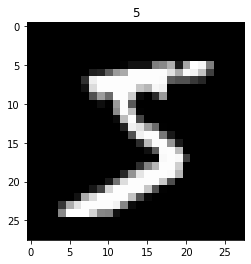

C:\Users\janek\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\janek\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


torch.Size([28, 28])
torch.Size([1, 28, 28])
tensor(7)
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3105 | test accuracy: 0.06


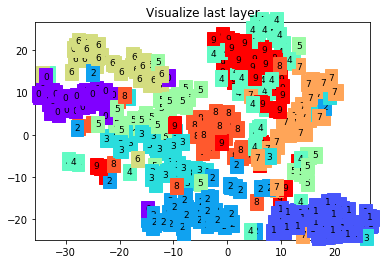

Epoch:  0 | train loss: 0.1289 | test accuracy: 0.87


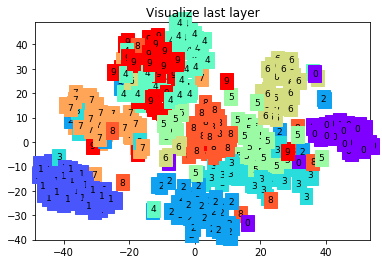

Epoch:  0 | train loss: 0.4050 | test accuracy: 0.93


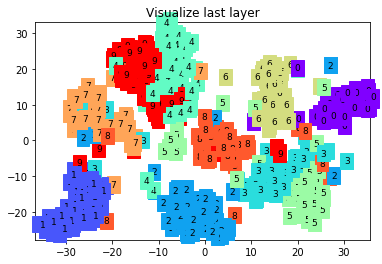

Epoch:  0 | train loss: 0.1955 | test accuracy: 0.95


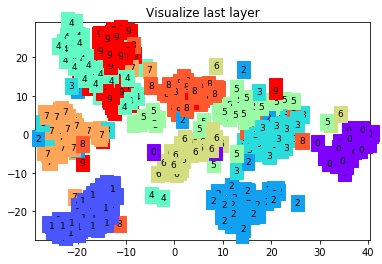

Epoch:  0 | train loss: 0.1237 | test accuracy: 0.96


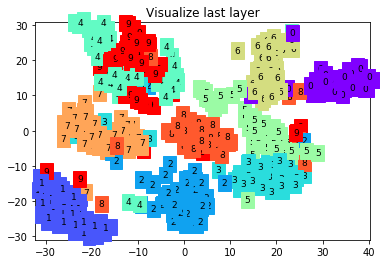

Epoch:  0 | train loss: 0.2220 | test accuracy: 0.96


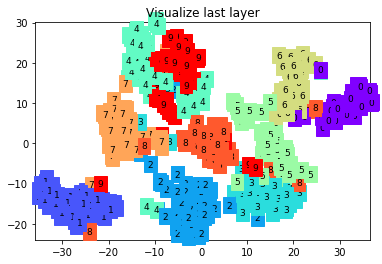

Epoch:  0 | train loss: 0.0241 | test accuracy: 0.97


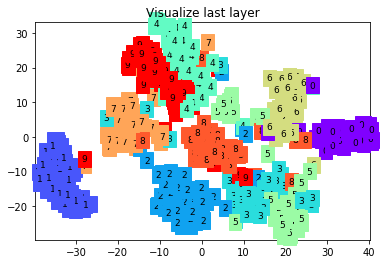

Epoch:  0 | train loss: 0.2145 | test accuracy: 0.97


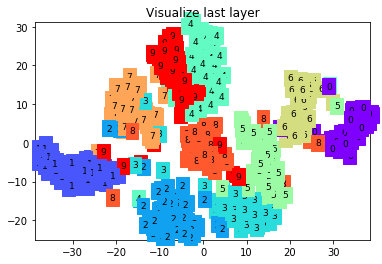

Epoch:  0 | train loss: 0.0445 | test accuracy: 0.97


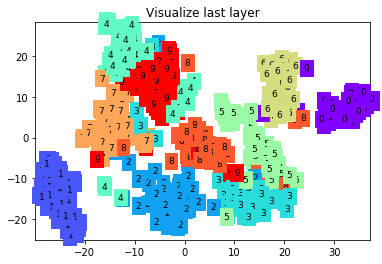

Epoch:  0 | train loss: 0.0576 | test accuracy: 0.98


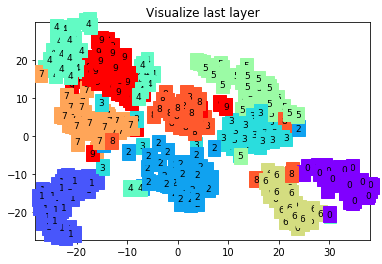

Epoch:  0 | train loss: 0.0311 | test accuracy: 0.98


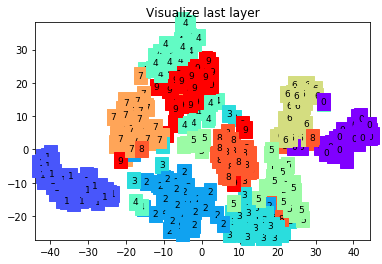

Epoch:  0 | train loss: 0.0269 | test accuracy: 0.98


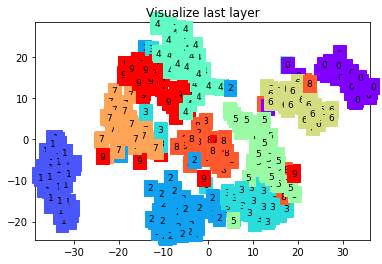

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
#matplotlib inline

torch.manual_seed(1)    # reproducible
# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = True   # set to False if you have downloaded

# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)
# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray') # 행과 열을 가진 행렬 형태의 2차원 데이터를 imshow 명령을 써서 2차원 자료의 크기를 색깔로 표시하는 것
plt.title('%i' % train_data.train_labels[0])
plt.show()

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# convert test data into Variable, pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
print(test_data.test_data[0].size())
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1)).type(torch.FloatTensor)[:2000]/255.  
print(test_x[0].size())
# shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.test_labels[:2000]
print(test_y[0])

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

acc5 = []
loss5 = []
plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            acc5.append(accuracy);
            loss5.append(loss)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
                labels = test_y.numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()


In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=11,              # filter size
                stride=1,                   # filter movement/step
                padding=5,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 11, 1, 5),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

acc11 = []
loss11 = []
plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            acc11.append(accuracy)
            loss11.append(loss.data)

plt.ioff()


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3108 | test accuracy: 0.11
Epoch:  0 | train loss: 0.1634 | test accuracy: 0.92
Epoch:  0 | train loss: 0.0869 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0604 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0468 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1473 | test accuracy: 0.96
Epoch:  0 | train loss: 0.2018 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0551 | test accuracy: 0.97
Epoch:  0 | train loss: 0.2177 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0553 | test accuracy:

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=21,              # filter size
                stride=1,                   # filter movement/step
                padding=10,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 21, 1, 10),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted


acc21 = []
loss21 = []
plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            acc21.append(accuracy)
            loss21.append(loss.data)
           
plt.ioff()


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(21, 21), stride=(1, 1), padding=(10, 10))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(21, 21), stride=(1, 1), padding=(10, 10))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.2994 | test accuracy: 0.17
Epoch:  0 | train loss: 0.3258 | test accuracy: 0.92
Epoch:  0 | train loss: 0.2179 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0237 | test accuracy: 0.94
Epoch:  0 | train loss: 0.3145 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1170 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1188 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0317 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0259 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0417 | test accur

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=1,              # filter size
                stride=1,                   # filter movement/step
                padding=0,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 1, 1, 0),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted


acc1 = []
loss1 = []
plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            acc1.append(accuracy)
            loss1.append(loss.data)

plt.ioff()


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3259 | test accuracy: 0.11
Epoch:  0 | train loss: 0.7941 | test accuracy: 0.76
Epoch:  0 | train loss: 0.4793 | test accuracy: 0.80
Epoch:  0 | train loss: 0.6305 | test accuracy: 0.82
Epoch:  0 | train loss: 0.3612 | test accuracy: 0.82
Epoch:  0 | train loss: 0.4193 | test accuracy: 0.82
Epoch:  0 | train loss: 0.4392 | test accuracy: 0.83
Epoch:  0 | train loss: 0.4362 | test accuracy: 0.83
Epoch:  0 | train loss: 0.3407 | test accuracy: 0.84
Epoch:  0 | train loss: 0.8458 | test accuracy: 0.83
Epoch:  0 | train loss: 0.4713

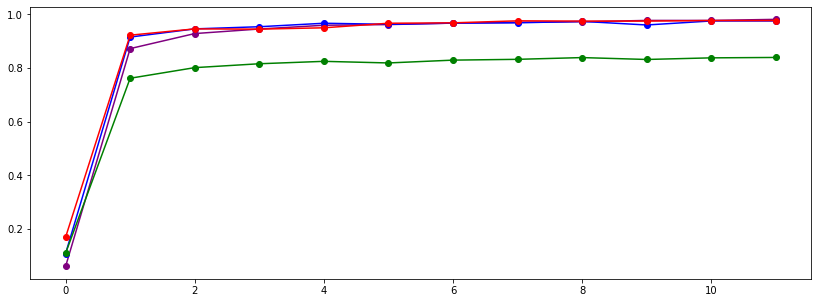

In [5]:
fig = plt.figure(figsize = (14,5))
plt.plot(acc5, label = 'size 5', color = "purple", marker = "o")
plt.plot(acc11, label = 'size 11', color = "blue", marker = "o")
plt.plot(acc21, label = 'size 21', color = "red", marker = "o")
plt.plot(acc1, label = 'size 1', color = "green", marker = "o")

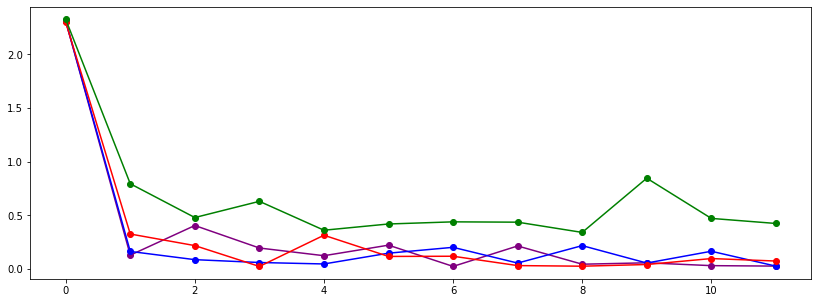

In [6]:
fig = plt.figure(figsize = (14,5))
plt.plot(loss5, label = 'size 5',color = "purple", marker = "o")
plt.plot(loss11, label = 'size 11',color = "blue", marker = "o")
plt.plot(loss21, label = 'size 21',color = "red", marker = "o")
plt.plot(loss1, label = 'size 1',color = "green", marker = "o")

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
                # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
                            # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 28 * 28, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted


testacc = []
trainloss = []

plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            testacc.append(accuracy)
            trainloss.append(loss.data)
    
plt.ioff()


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (out): Linear(in_features=25088, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3026 | test accuracy: 0.17
Epoch:  0 | train loss: 0.2663 | test accuracy: 0.91
Epoch:  0 | train loss: 0.1376 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0621 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0755 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1455 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0305 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1005 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0731 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1187 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0439 | test accuracy: 0.98
Epoch:  0 | train loss: 0.0434 | test accuracy: 0.98


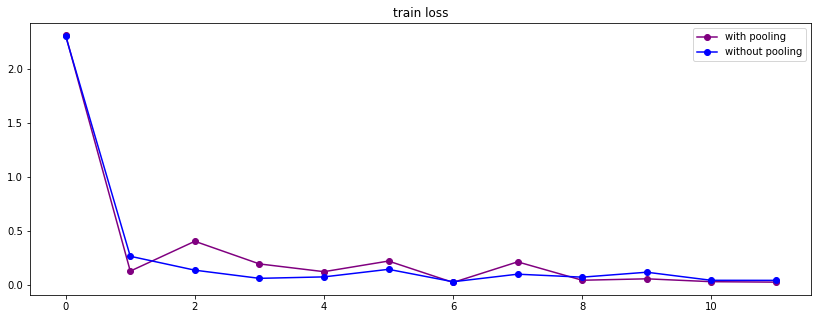

In [8]:
fig = plt.figure(figsize = (14,5))
plt.title("train loss")
plt.plot(loss5, label = 'with pooling',color = "purple", marker = "o")
plt.plot(trainloss, label = 'without pooling',color = "blue", marker = "o")
plt.legend()

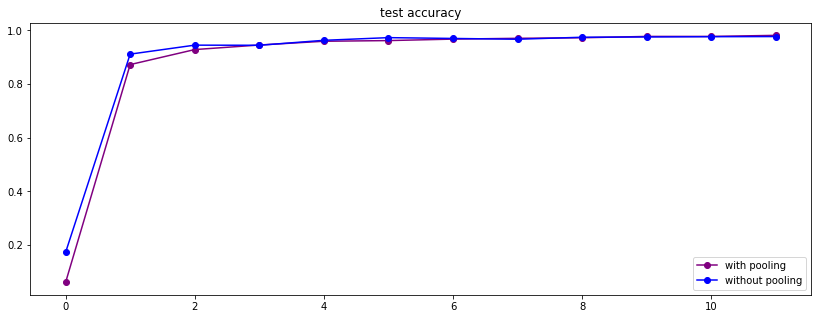

In [9]:
fig = plt.figure(figsize = (14,5))
plt.title("test accuracy")
plt.plot(acc5, label = 'with pooling', color = "purple", marker = "o")
plt.plot(testacc, label = 'without pooling', color = "blue", marker = "o")
plt.legend()

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.Sigmoid(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.Sigmoid(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted


testacc = []
trainloss = []

plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            testacc.append(accuracy)
            trainloss.append(loss.data)
            
            
plt.ioff()


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3920 | test accuracy: 0.10
Epoch:  0 | train loss: 2.3043 | test accuracy: 0.12
Epoch:  0 | train loss: 2.2102 | test accuracy: 0.35
Epoch:  0 | train loss: 0.7889 | test accuracy: 0.75
Epoch:  0 | train loss: 0.2904 | test accuracy: 0.85
Epoch:  0 | train loss: 0.3951 | test accuracy: 0.88
Epoch:  0 | train loss: 0.4896 | test accuracy: 0.89
Epoch:  0 | train loss: 0.1678 | test accuracy: 0.91
Epoch:  0 | train loss: 0.2648 | test accuracy: 0.90
Epoch:  0 | train loss: 0.2561 | test accurac

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.Tanh(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.Tanh(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted


acctanh = []
losstanh = []

plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            acctanh.append(accuracy)
            losstanh.append(loss.data)
            
            
plt.ioff()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3065 | test accuracy: 0.14
Epoch:  0 | train loss: 0.3278 | test accuracy: 0.88
Epoch:  0 | train loss: 0.1919 | test accuracy: 0.92
Epoch:  0 | train loss: 0.1164 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1492 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0748 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0381 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1327 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1203 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0431 | test accuracy: 0.9

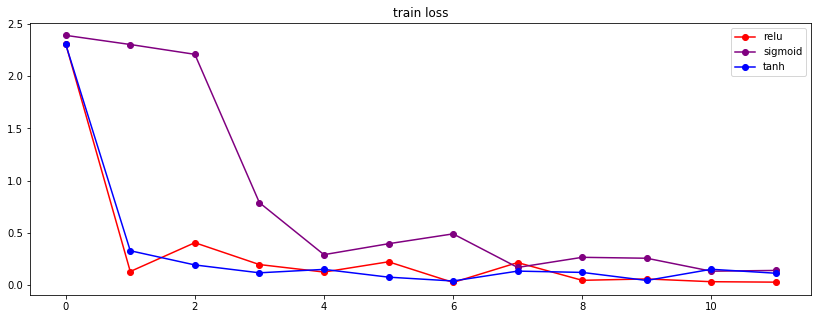

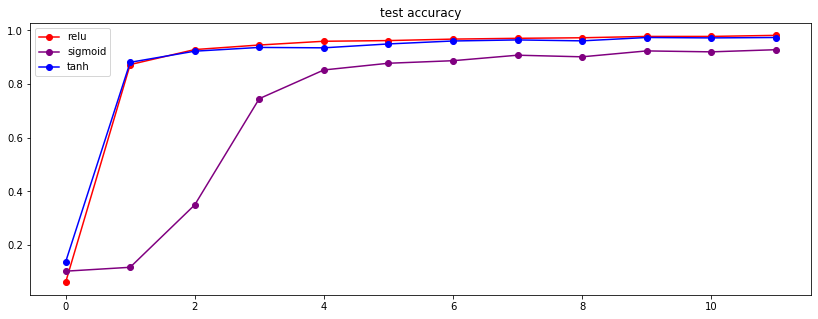

In [12]:
fig = plt.figure(figsize = (14,5))
plt.plot(loss5, label = 'relu',color = "red", marker = "o")
plt.plot(trainloss, label = 'sigmoid',color = "purple", marker = "o")
plt.plot(losstanh, label = 'tanh',color = "blue", marker = "o")
plt.title("train loss")
plt.legend()

fig = plt.figure(figsize = (14,5))
plt.plot(acc5, label = 'relu', color = "red", marker = "o")
plt.plot(testacc, label = 'sigmoid', color = "purple", marker = "o")
plt.plot(acctanh, label = 'tanh', color = "blue", marker = "o")
plt.title("test accuracy")
plt.legend()

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adagrad(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted


accgrad = []
lossgrad = []
plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            accgrad.append(accuracy);
            lossgrad.append(loss)
            
plt.ioff()


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.2994 | test accuracy: 0.08
Epoch:  0 | train loss: 0.9665 | test accuracy: 0.79
Epoch:  0 | train loss: 0.6166 | test accuracy: 0.81
Epoch:  0 | train loss: 0.6159 | test accuracy: 0.84
Epoch:  0 | train loss: 0.3420 | test accuracy: 0.86
Epoch:  0 | train loss: 0.5080 | test accuracy: 0.87
Epoch:  0 | train loss: 0.2550 | test accuracy: 0.87
Epoch:  0 | train loss: 0.3860 | test accuracy: 0.88
Epoch:  0 | train loss: 0.3896 | test accuracy: 0.88
Epoch:  0 | train loss: 0.2891 | test accuracy: 0.8

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adadelta(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted


accdelta = []
lossdelta = []
plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            accdelta.append(accuracy);
            lossdelta.append(loss)
            
plt.ioff()


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3089 | test accuracy: 0.03
Epoch:  0 | train loss: 2.2971 | test accuracy: 0.05
Epoch:  0 | train loss: 2.2858 | test accuracy: 0.07
Epoch:  0 | train loss: 2.2898 | test accuracy: 0.09
Epoch:  0 | train loss: 2.2904 | test accuracy: 0.13
Epoch:  0 | train loss: 2.2789 | test accuracy: 0.16
Epoch:  0 | train loss: 2.2644 | test accuracy: 0.18
Epoch:  0 | train loss: 2.2706 | test accuracy: 0.19
Epoch:  0 | train loss: 2.2752 | test accuracy: 0.22
Epoch:  0 | train loss: 2.2496 | test accuracy: 0.2

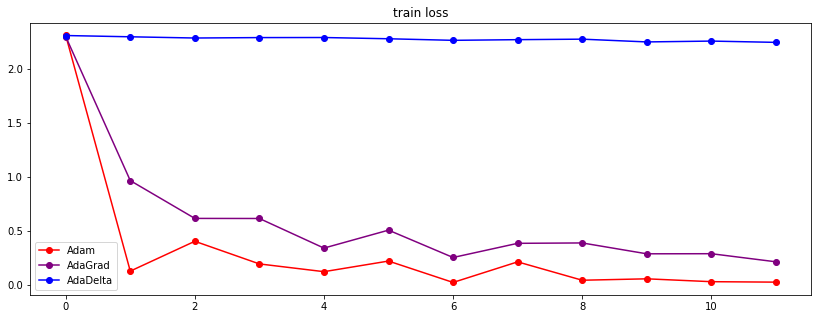

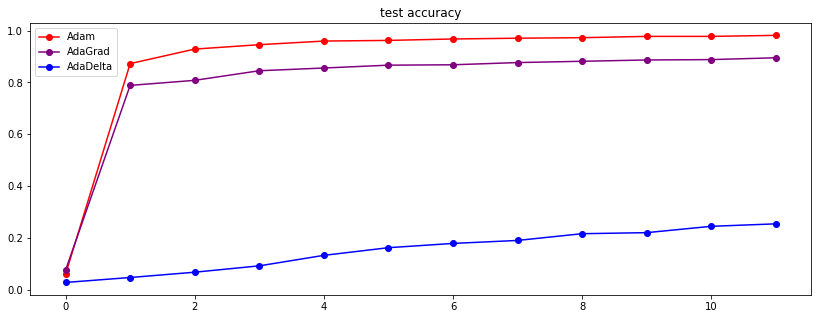

In [15]:
fig = plt.figure(figsize = (14,5))
plt.plot(loss5, label = 'Adam',color = "red", marker = "o")
plt.plot(lossgrad, label = 'AdaGrad',color = "purple", marker = "o")
plt.plot(lossdelta, label = 'AdaDelta',color = "blue", marker = "o")
plt.title("train loss")
plt.legend()

fig = plt.figure(figsize = (14,5))
plt.plot(acc5, label = 'Adam', color = "red", marker = "o")
plt.plot(accgrad, label = 'AdaGrad', color = "purple", marker = "o")
plt.plot(accdelta, label = 'AdaDelta', color = "blue", marker = "o")
plt.title("test accuracy")
plt.legend()

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes
        torch.nn.init.xavier_uniform(self.out.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization
    

cnn = CNN()
print(cnn)  # net architecture


optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

accw = []
lossw = []
plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            accw.append(accuracy);
            lossw.append(loss)
            
plt.ioff()


C:\Users\janek\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3175 | test accuracy: 0.10
Epoch:  0 | train loss: 0.4554 | test accuracy: 0.89
Epoch:  0 | train loss: 0.2389 | test accuracy: 0.92
Epoch:  0 | train loss: 0.1977 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0883 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1234 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0296 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0245 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1262 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0626 | test accuracy: 0.9

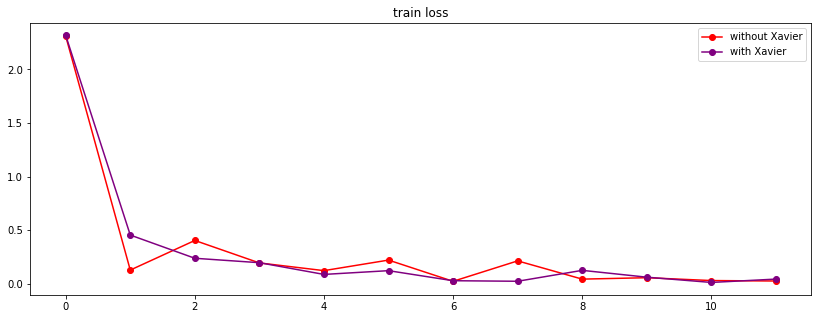

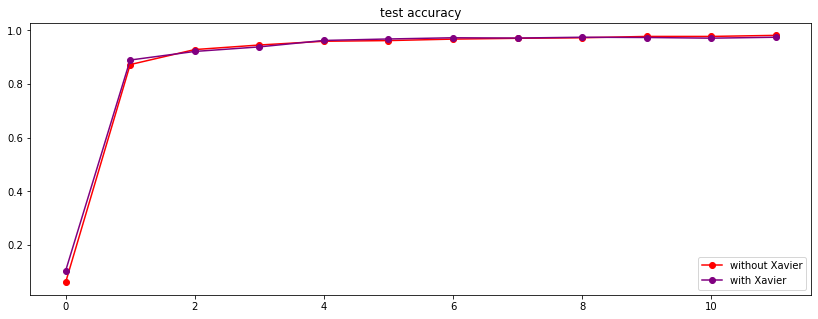

In [17]:
fig = plt.figure(figsize = (14,5))
plt.plot(loss5, label = 'without Xavier',color = "red", marker = "o")
plt.plot(lossw, label = 'with Xavier',color = "purple", marker = "o")
plt.title("train loss")
plt.legend()

fig = plt.figure(figsize = (14,5))
plt.plot(acc5, label = 'without Xavier', color = "red", marker = "o")
plt.plot(accw, label = 'with Xavier', color = "purple", marker = "o")
plt.title("test accuracy")
plt.legend()

In [18]:
EPOCH = 2
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted


accep = []
lossep = []
plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            accep.append(accuracy);
            lossep.append(loss)
            
plt.ioff()


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3149 | test accuracy: 0.10
Epoch:  0 | train loss: 0.1888 | test accuracy: 0.89
Epoch:  0 | train loss: 0.2095 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0765 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0998 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0802 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0578 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1264 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0211 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0193 | test accuracy: 0.9

In [19]:
EPOCH = 1
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.Dropout(),
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.Dropout(),
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted


accdrop = []
lossdrop = []
plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            accdrop.append(accuracy);
            lossdrop.append(loss)
            
plt.ioff()


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.2866 | test accuracy: 0.12
Epoch:  0 | train loss: 0.2319 | test accuracy: 0.89
Epoch:  0 | train loss: 0.2748 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0909 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1848 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0510 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0948 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0869 | test accuracy: 0.97
Epoch:  0 | train loss: 0.

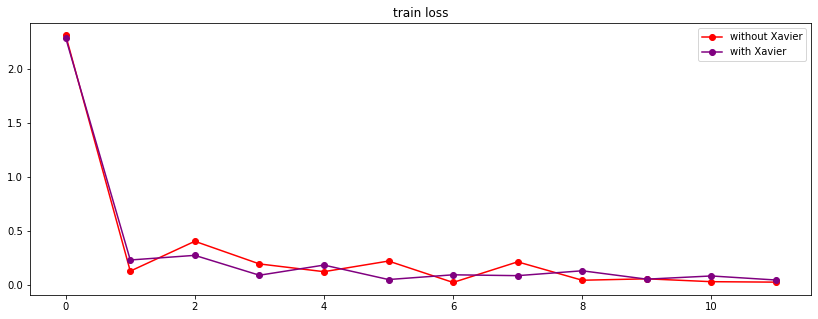

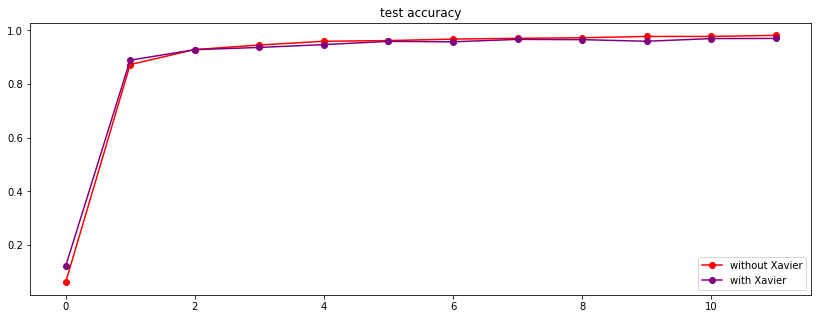

In [20]:
fig = plt.figure(figsize = (14,5))
plt.plot(loss5, label = 'without Xavier',color = "red", marker = "o")
plt.plot(lossdrop, label = 'with Xavier',color = "purple", marker = "o")
plt.title("train loss")
plt.legend()

fig = plt.figure(figsize = (14,5))
plt.plot(acc5, label = 'without Xavier', color = "red", marker = "o")
plt.plot(accdrop, label = 'with Xavier', color = "purple", marker = "o")
plt.title("test accuracy")
plt.legend()

In [21]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.Dropout(),
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted


accdrop = []
lossdrop = []
plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            accdrop.append(accuracy);
            lossdrop.append(loss)
            
plt.ioff()


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.2991 | test accuracy: 0.13
Epoch:  0 | train loss: 0.3060 | test accuracy: 0.87
Epoch:  0 | train loss: 0.2139 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1008 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0309 | test accuracy: 0.96
Epoch:  0 | train loss: 0.3191 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0779 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1198 | test accuracy: 0.96
Epoch:  0 | train loss: 0.2519 | test accuracy: 0.97
Epoch:  0 | 

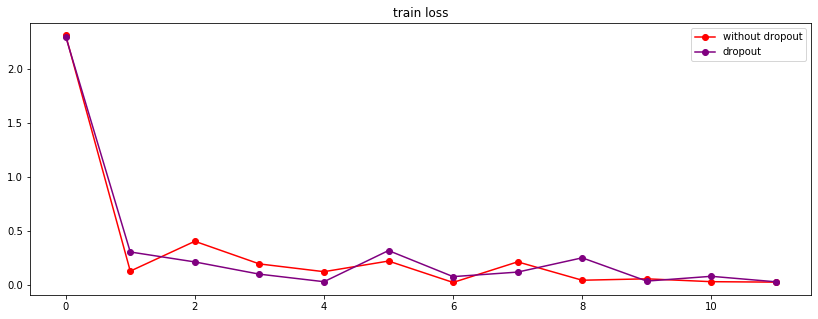

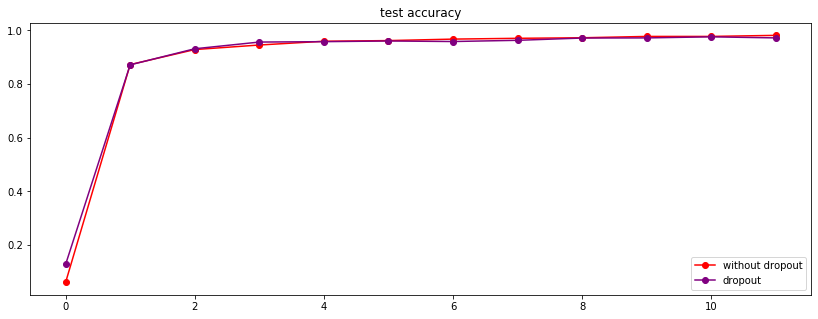

In [22]:
fig = plt.figure(figsize = (14,5))
plt.plot(loss5, label = 'without dropout',color = "red", marker = "o")
plt.plot(lossdrop, label = 'dropout',color = "purple", marker = "o")
plt.title("train loss")
plt.legend()

fig = plt.figure(figsize = (14,5))
plt.plot(acc5, label = 'without dropout', color = "red", marker = "o")
plt.plot(accdrop, label = 'dropout', color = "purple", marker = "o")
plt.title("test accuracy")
plt.legend()

In [23]:
reacc = []
reloss = []
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR, weight_decay = 1e-5)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted


plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)   # batch x
        b_y = Variable(y)   # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            reacc.append(accuracy);
            reloss.append(loss)
            
plt.ioff()


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3131 | test accuracy: 0.14
Epoch:  0 | train loss: 0.3688 | test accuracy: 0.90
Epoch:  0 | train loss: 0.2007 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1060 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0338 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0873 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0380 | test accuracy: 0.97
Epoch:  0 | train loss: 0.2248 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1761 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0199 | test accuracy: 0.9

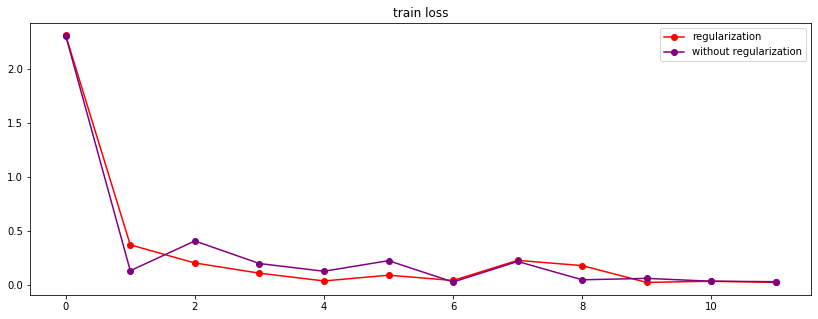

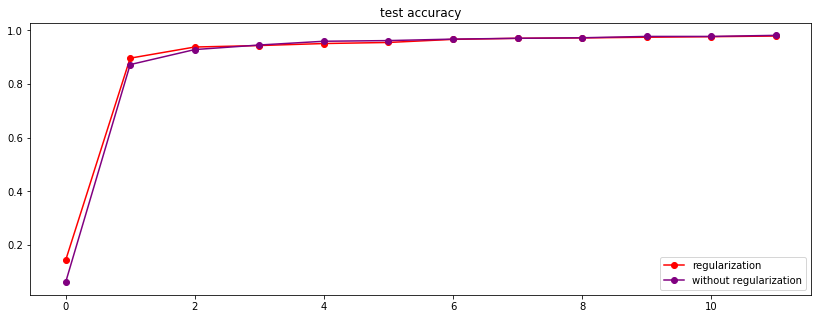

In [24]:
fig = plt.figure(figsize = (14,5))
plt.plot(reloss, label = 'regularization',color = "red", marker = "o")
plt.plot(loss5, label = 'without regularization',color = "purple", marker = "o")

plt.title("train loss")
plt.legend()

fig = plt.figure(figsize = (14,5))
plt.plot(reacc, label = 'regularization',color = "red", marker = "o")
plt.plot(acc5, label = 'without regularization',color = "purple", marker = "o")

plt.title("test accuracy")
plt.legend()

In [25]:
import torch
import torchvision
import torchvision.transforms as transforms


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

import torch.nn as nn
import torch.nn.functional as F

Files already downloaded and verified
Files already downloaded and verified


In [26]:
kacc = []
kacc.append([])
kloss = []
kloss.append([])
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            kloss[0].append(running_loss)
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    kacc[0].append(100 * class_correct[i] / class_total[i])

# del dataiter

cpu
start traning.
[1,  2000] loss: 2.195
[1,  4000] loss: 1.804
[1,  6000] loss: 1.623
[1,  8000] loss: 1.532
[1, 10000] loss: 1.479
[1, 12000] loss: 1.419
[2,  2000] loss: 1.354
[2,  4000] loss: 1.303
[2,  6000] loss: 1.283
[2,  8000] loss: 1.276
[2, 10000] loss: 1.229
[2, 12000] loss: 1.205
Finished Training
Accuracy of the network on the 10000 test images: 57 %
Accuracy of plane : 71 %
Accuracy of   car : 84 %
Accuracy of  bird : 35 %
Accuracy of   cat : 15 %
Accuracy of  deer : 44 %
Accuracy of   dog : 58 %
Accuracy of  frog : 71 %
Accuracy of horse : 72 %
Accuracy of  ship : 55 %
Accuracy of truck : 61 %


In [27]:
kacc.append([])
kloss.append([])

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 7)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 7)
        self.fc1 = nn.Linear(16 * 3 * 3, 120) #height = width = sqrt( E / batch_size / n_channels)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            kloss[1].append(running_loss)
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    kacc[1].append(100 * class_correct[i] / class_total[i])


cpu
start traning.
[1,  2000] loss: 2.147
[1,  4000] loss: 1.796
[1,  6000] loss: 1.662
[1,  8000] loss: 1.591
[1, 10000] loss: 1.518
[1, 12000] loss: 1.468
[2,  2000] loss: 1.390
[2,  4000] loss: 1.379
[2,  6000] loss: 1.351
[2,  8000] loss: 1.348
[2, 10000] loss: 1.333
[2, 12000] loss: 1.318
Finished Training
Accuracy of the network on the 10000 test images: 53 %
Accuracy of plane : 56 %
Accuracy of   car : 66 %
Accuracy of  bird : 47 %
Accuracy of   cat : 27 %
Accuracy of  deer : 27 %
Accuracy of   dog : 60 %
Accuracy of  frog : 71 %
Accuracy of horse : 57 %
Accuracy of  ship : 72 %
Accuracy of truck : 50 %


In [28]:
kacc.append([])
kloss.append([])

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 2)
        self.fc1 = nn.Linear(16 * 7 * 7, 120) #height = width = sqrt( E / batch_size / n_channels)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            kloss[2].append(running_loss)
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    kacc[2].append(100 * class_correct[i] / class_total[i])


cpu
start traning.
[1,  2000] loss: 2.218
[1,  4000] loss: 1.906
[1,  6000] loss: 1.690
[1,  8000] loss: 1.546
[1, 10000] loss: 1.459
[1, 12000] loss: 1.426
[2,  2000] loss: 1.314
[2,  4000] loss: 1.300
[2,  6000] loss: 1.255
[2,  8000] loss: 1.222
[2, 10000] loss: 1.175
[2, 12000] loss: 1.139
Finished Training
Accuracy of the network on the 10000 test images: 60 %
Accuracy of plane : 55 %
Accuracy of   car : 69 %
Accuracy of  bird : 39 %
Accuracy of   cat : 51 %
Accuracy of  deer : 42 %
Accuracy of   dog : 43 %
Accuracy of  frog : 78 %
Accuracy of horse : 72 %
Accuracy of  ship : 77 %
Accuracy of truck : 73 %


In [29]:
kacc.append([])
kloss.append([])

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 4)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #height = width = sqrt( E / batch_size / n_channels)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            kloss[3].append(running_loss)
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    kacc[3].append(100 * class_correct[i] / class_total[i])


cpu
start traning.
[1,  2000] loss: 2.214
[1,  4000] loss: 1.877
[1,  6000] loss: 1.665
[1,  8000] loss: 1.514
[1, 10000] loss: 1.481
[1, 12000] loss: 1.420
[2,  2000] loss: 1.348
[2,  4000] loss: 1.316
[2,  6000] loss: 1.306
[2,  8000] loss: 1.279
[2, 10000] loss: 1.249
[2, 12000] loss: 1.234
Finished Training
Accuracy of the network on the 10000 test images: 57 %
Accuracy of plane : 66 %
Accuracy of   car : 74 %
Accuracy of  bird : 43 %
Accuracy of   cat : 27 %
Accuracy of  deer : 47 %
Accuracy of   dog : 51 %
Accuracy of  frog : 82 %
Accuracy of horse : 53 %
Accuracy of  ship : 70 %
Accuracy of truck : 60 %


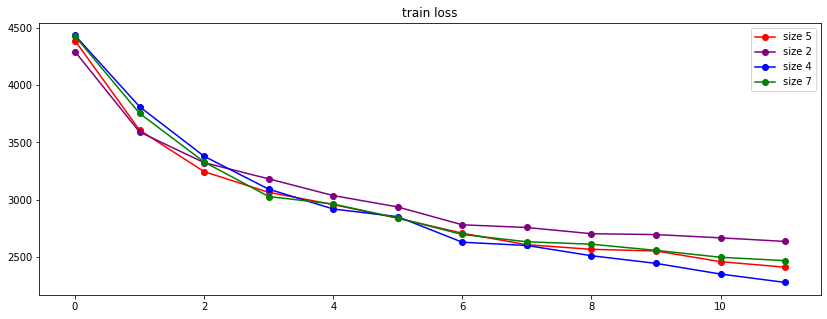

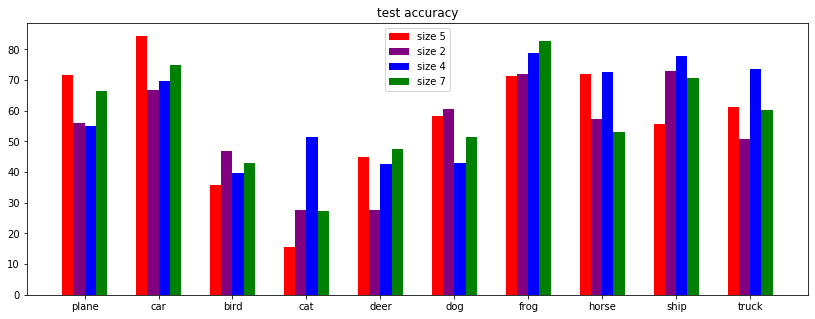

In [30]:
fig = plt.figure(figsize = (14,5))
plt.plot(kloss[0], label = 'size 5',color = "red", marker = "o")
plt.plot(kloss[1], label = 'size 2',color = "purple", marker = "o")
plt.plot(kloss[2], label = 'size 4',color = "blue", marker = "o")
plt.plot(kloss[3], label = 'size 7',color = "green", marker = "o")
plt.title("train loss")
plt.legend()


bar_width = 0.15
index = np.arange(len(classes))
fig = plt.figure(figsize = (14,5))
plt.bar(index- (3/2)*bar_width, kacc[0], bar_width,label = 'size 5', color = "red")
plt.bar(index - bar_width/2,kacc[1], bar_width,label = 'size 2',color = "purple")
plt.bar(index + bar_width/2,kacc[2], bar_width,label = 'size 4',color = "blue")
plt.bar(index + (3/2)*bar_width,kacc[3], bar_width,label = 'size 7',color = "green")
plt.title("test accuracy")
plt.xticks(index,classes)
plt.legend()

In [31]:
pacc = []
ploss = []
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 24 * 24, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 16 * 24 * 24)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            ploss.append(running_loss)
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    pacc.append(100 * class_correct[i] / class_total[i])


cpu
start traning.
[1,  2000] loss: 2.001
[1,  4000] loss: 1.697
[1,  6000] loss: 1.582
[1,  8000] loss: 1.500
[1, 10000] loss: 1.460
[1, 12000] loss: 1.413
[2,  2000] loss: 1.309
[2,  4000] loss: 1.295
[2,  6000] loss: 1.271
[2,  8000] loss: 1.254
[2, 10000] loss: 1.204
[2, 12000] loss: 1.204
Finished Training
Accuracy of the network on the 10000 test images: 57 %
Accuracy of plane : 66 %
Accuracy of   car : 73 %
Accuracy of  bird : 37 %
Accuracy of   cat : 32 %
Accuracy of  deer : 47 %
Accuracy of   dog : 44 %
Accuracy of  frog : 82 %
Accuracy of horse : 67 %
Accuracy of  ship : 62 %
Accuracy of truck : 61 %


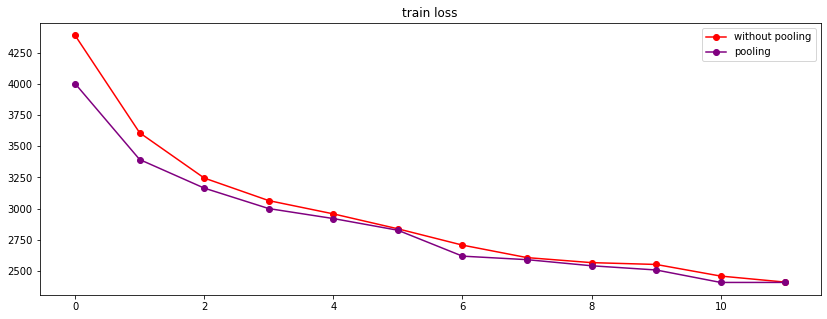

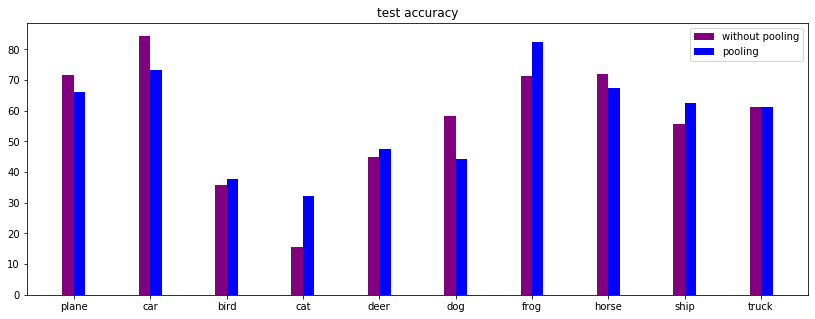

In [32]:
fig = plt.figure(figsize = (14,5))
plt.plot(kloss[0], label = 'without pooling',color = "red", marker = "o")
plt.plot(ploss, label = 'pooling',color = "purple", marker = "o")

plt.title("train loss")
plt.legend()


bar_width = 0.15
index = np.arange(len(classes))
fig = plt.figure(figsize = (14,5))

plt.bar(index - bar_width/2,kacc[0], bar_width,label = 'without pooling',color = "purple")
plt.bar(index + bar_width/2,pacc, bar_width,label = 'pooling',color = "blue")

plt.title("test accuracy")
plt.xticks(index,classes)
plt.legend()

In [33]:
atacc = []
atacc.append([])
atloss = []
atloss.append([])
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = self.pool(F.sigmoid(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            atloss[0].append(running_loss)
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    atacc[0].append(100 * class_correct[i] / class_total[i])

cpu
start traning.


C:\Users\janek\Anaconda3\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,  2000] loss: 2.314
[1,  4000] loss: 2.314
[1,  6000] loss: 2.314
[1,  8000] loss: 2.312
[1, 10000] loss: 2.312
[1, 12000] loss: 2.310
[2,  2000] loss: 2.310
[2,  4000] loss: 2.310
[2,  6000] loss: 2.307
[2,  8000] loss: 2.307
[2, 10000] loss: 2.307
[2, 12000] loss: 2.308
Finished Training
Accuracy of the network on the 10000 test images: 10 %
Accuracy of plane :  0 %
Accuracy of   car : 100 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %


In [34]:
atacc.append([])
atloss.append([])
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            atloss[1].append(running_loss)
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    atacc[1].append(100 * class_correct[i] / class_total[i])

cpu
start traning.


C:\Users\janek\Anaconda3\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[1,  2000] loss: 2.012
[1,  4000] loss: 1.680
[1,  6000] loss: 1.546
[1,  8000] loss: 1.453
[1, 10000] loss: 1.422
[1, 12000] loss: 1.362
[2,  2000] loss: 1.313
[2,  4000] loss: 1.272
[2,  6000] loss: 1.278
[2,  8000] loss: 1.258
[2, 10000] loss: 1.201
[2, 12000] loss: 1.217
Finished Training
Accuracy of the network on the 10000 test images: 57 %
Accuracy of plane : 62 %
Accuracy of   car : 68 %
Accuracy of  bird : 62 %
Accuracy of   cat : 34 %
Accuracy of  deer : 37 %
Accuracy of   dog : 35 %
Accuracy of  frog : 67 %
Accuracy of horse : 66 %
Accuracy of  ship : 82 %
Accuracy of truck : 58 %


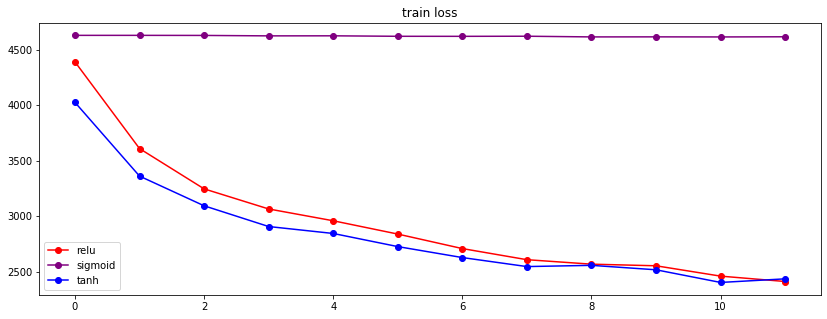

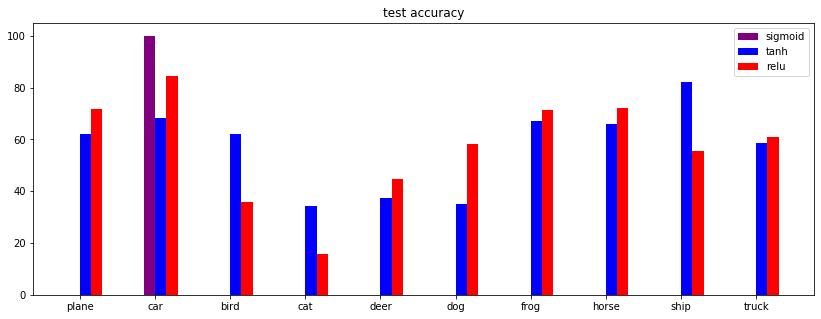

In [35]:
fig = plt.figure(figsize = (14,5))
plt.plot(kloss[0], label = 'relu',color = "red", marker = "o")
plt.plot(atloss[0], label = 'sigmoid',color = "purple", marker = "o")
plt.plot(atloss[1], label = 'tanh',color = "blue", marker = "o")

plt.title("train loss")
plt.legend()

bar_width = 0.15
index = np.arange(len(classes))
fig = plt.figure(figsize = (14,5))

plt.bar(index - bar_width/2,atacc[0], bar_width,label = 'sigmoid',color = "purple")
plt.bar(index + bar_width/2,atacc[1], bar_width,label = 'tanh',color = "blue")
plt.bar(index + 3*bar_width/2,kacc[0], bar_width,label = 'relu',color = "red")

plt.title("test accuracy")
plt.xticks(index,classes)
plt.legend()

In [36]:
oacc = []
oacc.append([])
oloss = []
oloss.append([])
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            oloss[0].append(running_loss)
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    oacc[0].append(100 * class_correct[i] / class_total[i])

cpu
start traning.
[1,  2000] loss: 1.909
[1,  4000] loss: 1.618
[1,  6000] loss: 1.526
[1,  8000] loss: 1.473
[1, 10000] loss: 1.434
[1, 12000] loss: 1.406
[2,  2000] loss: 1.352
[2,  4000] loss: 1.372
[2,  6000] loss: 1.317
[2,  8000] loss: 1.323
[2, 10000] loss: 1.299
[2, 12000] loss: 1.301
Finished Training
Accuracy of the network on the 10000 test images: 53 %
Accuracy of plane : 67 %
Accuracy of   car : 79 %
Accuracy of  bird : 40 %
Accuracy of   cat : 21 %
Accuracy of  deer : 43 %
Accuracy of   dog : 54 %
Accuracy of  frog : 65 %
Accuracy of horse : 58 %
Accuracy of  ship : 43 %
Accuracy of truck : 58 %


In [37]:
oacc.append([])
oloss.append([])
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            oloss[1].append(running_loss)
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    oacc[1].append(100 * class_correct[i] / class_total[i])

cpu
start traning.
[1,  2000] loss: 1.992
[1,  4000] loss: 1.718
[1,  6000] loss: 1.633
[1,  8000] loss: 1.557
[1, 10000] loss: 1.535
[1, 12000] loss: 1.529
[2,  2000] loss: 1.463
[2,  4000] loss: 1.460
[2,  6000] loss: 1.465
[2,  8000] loss: 1.447
[2, 10000] loss: 1.427
[2, 12000] loss: 1.401
Finished Training
Accuracy of the network on the 10000 test images: 50 %
Accuracy of plane : 59 %
Accuracy of   car : 67 %
Accuracy of  bird : 49 %
Accuracy of   cat : 33 %
Accuracy of  deer : 37 %
Accuracy of   dog : 23 %
Accuracy of  frog : 55 %
Accuracy of horse : 72 %
Accuracy of  ship : 60 %
Accuracy of truck : 50 %


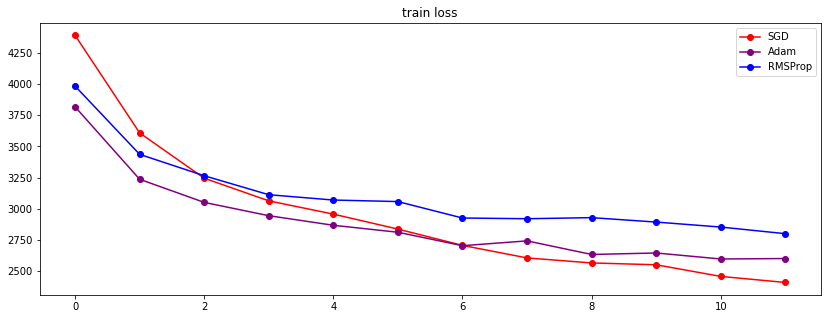

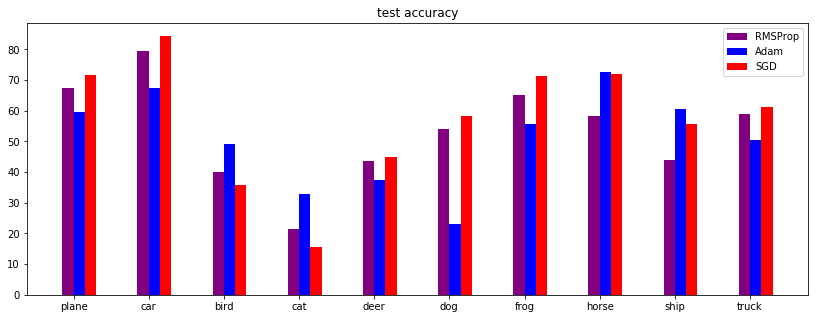

In [38]:
fig = plt.figure(figsize = (14,5))
plt.plot(kloss[0], label = 'SGD',color = "red", marker = "o")
plt.plot(oloss[0], label = 'Adam',color = "purple", marker = "o")
plt.plot(oloss[1], label = 'RMSProp',color = "blue", marker = "o")

plt.title("train loss")
plt.legend()

bar_width = 0.15
index = np.arange(len(classes))
fig = plt.figure(figsize = (14,5))

plt.bar(index - bar_width/2,oacc[0], bar_width,label = 'RMSProp',color = "purple")
plt.bar(index + bar_width/2,oacc[1], bar_width,label = 'Adam',color = "blue")
plt.bar(index + 3*bar_width/2,kacc[0], bar_width,label = 'SGD',color = "red")

plt.title("test accuracy")
plt.xticks(index,classes)
plt.legend()

In [39]:
xacc = []
xloss = []
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            xloss.append(running_loss)
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    xacc.append(100 * class_correct[i] / class_total[i])

cpu
start traning.
[1,  2000] loss: 1.830
[1,  4000] loss: 1.580
[1,  6000] loss: 1.463
[1,  8000] loss: 1.451
[1, 10000] loss: 1.378
[1, 12000] loss: 1.368
[2,  2000] loss: 1.258
[2,  4000] loss: 1.273
[2,  6000] loss: 1.241
[2,  8000] loss: 1.262
[2, 10000] loss: 1.227
[2, 12000] loss: 1.207
Finished Training
Accuracy of the network on the 10000 test images: 59 %
Accuracy of plane : 72 %
Accuracy of   car : 71 %
Accuracy of  bird : 35 %
Accuracy of   cat : 46 %
Accuracy of  deer : 48 %
Accuracy of   dog : 49 %
Accuracy of  frog : 65 %
Accuracy of horse : 71 %
Accuracy of  ship : 64 %
Accuracy of truck : 67 %


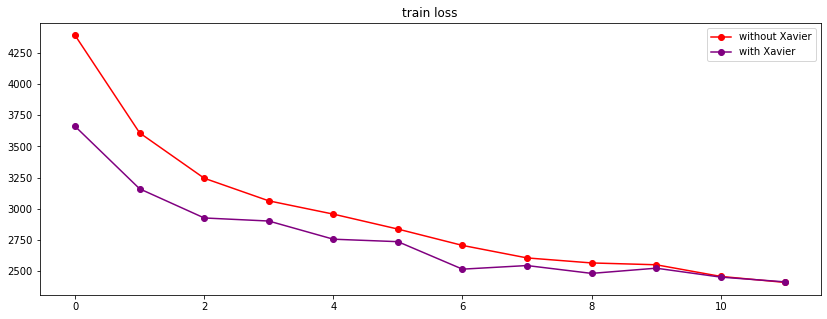

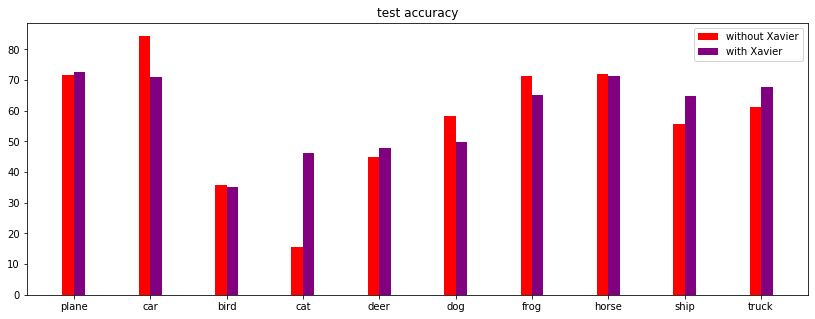

In [40]:
fig = plt.figure(figsize = (14,5))
plt.plot(kloss[0], label = 'without Xavier',color = "red", marker = "o")
plt.plot(xloss, label = 'with Xavier',color = "purple", marker = "o")

plt.title("train loss")
plt.legend()


bar_width = 0.15
index = np.arange(len(classes))
fig = plt.figure(figsize = (14,5))

plt.bar(index - bar_width/2,kacc[0], bar_width,label = 'without Xavier',color = "red")
plt.bar(index + bar_width/2,xacc, bar_width,label = 'with Xavier',color = "purple")

plt.title("test accuracy")
plt.xticks(index,classes)
plt.legend()

In [41]:
dacc = []
dloss = []
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        nn.Dropout()
        self.fc2 = nn.Linear(120, 84)
        nn.Dropout()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print('start traning.')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            dloss.append(running_loss)
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    dacc.append(100 * class_correct[i] / class_total[i])

# del dataiter

cpu
start traning.
[1,  2000] loss: 2.159
[1,  4000] loss: 1.780
[1,  6000] loss: 1.626
[1,  8000] loss: 1.554
[1, 10000] loss: 1.474
[1, 12000] loss: 1.424
[2,  2000] loss: 1.328
[2,  4000] loss: 1.313
[2,  6000] loss: 1.254
[2,  8000] loss: 1.223
[2, 10000] loss: 1.233
[2, 12000] loss: 1.204
Finished Training
Accuracy of the network on the 10000 test images: 57 %
Accuracy of plane : 62 %
Accuracy of   car : 48 %
Accuracy of  bird : 49 %
Accuracy of   cat : 27 %
Accuracy of  deer : 42 %
Accuracy of   dog : 59 %
Accuracy of  frog : 64 %
Accuracy of horse : 72 %
Accuracy of  ship : 81 %
Accuracy of truck : 68 %


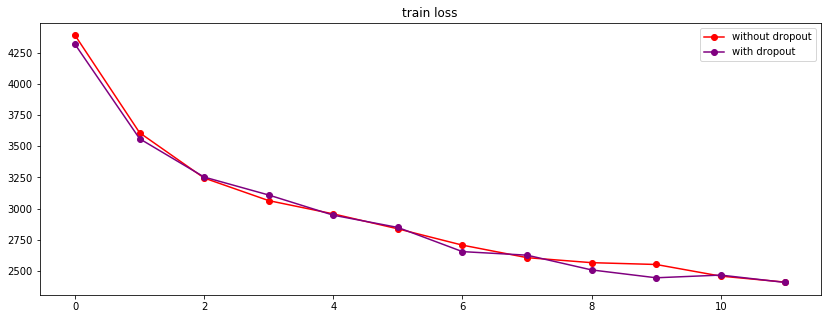

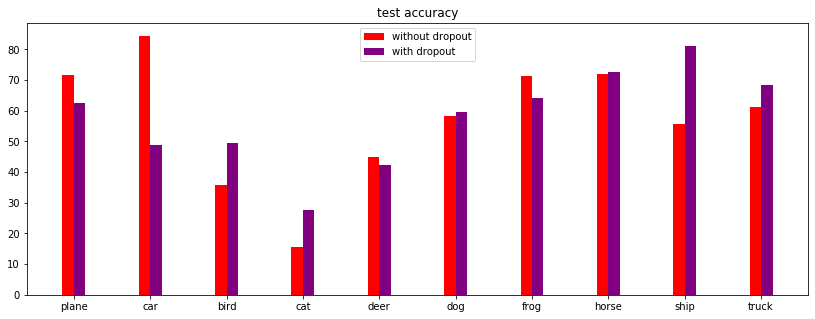

In [42]:
fig = plt.figure(figsize = (14,5))
plt.plot(kloss[0], label = 'without dropout',color = "red", marker = "o")
plt.plot(dloss, label = 'with dropout',color = "purple", marker = "o")

plt.title("train loss")
plt.legend()


bar_width = 0.15
index = np.arange(len(classes))
fig = plt.figure(figsize = (14,5))

plt.bar(index - bar_width/2,kacc[0], bar_width,label = 'without dropout',color = "red")
plt.bar(index + bar_width/2,dacc, bar_width,label = 'with dropout',color = "purple")

plt.title("test accuracy")
plt.xticks(index,classes)
plt.legend()

torch.Size([60000, 28, 28])
torch.Size([60000])


C:\Users\janek\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\janek\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


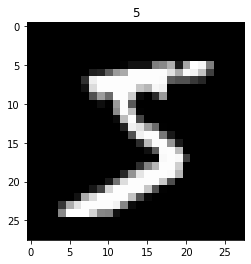

C:\Users\janek\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\janek\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\Users\janek\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.2883 | test accuracy: 0.10
Epoch:  0 | train loss: 0.8712 | test accuracy: 0.58
Epoch:  0 | train loss: 0.9341 | test accuracy: 0.72
Epoch:  0 | train loss: 0.7127 | test accuracy: 0.80
Epoch:  0 | train loss: 0.2352 | test accuracy: 0.88
Epoch:  0 | train loss: 0.2445 | test accuracy: 0.89
Epoch:  0 | train loss: 0.3177 | test accuracy: 0.90
Epoch:  0 | train loss: 0.3921 | test accuracy: 0.90
Epoch:  0 | train loss: 0.1699 | test accuracy: 0.92
Epoch:  0 | train loss: 0.2709 | test accuracy: 0.92
Epoch:  0 | train loss: 0.1222 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2899 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0294 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1771 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1851 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0651 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0407 | test accurac

In [43]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
TIME_STEP = 28          # rnn time step / image height
INPUT_SIZE = 28         # rnn input size / image width
LR = 0.01               # learning rate
DOWNLOAD_MNIST = True   # set to True if haven't download the data

# Mnist digital dataset
train_data = dsets.MNIST(
    root='./mnist/',
    train=True,                         # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,            # download it if you don't have it
)

# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

# Data Loader for easy mini-batch return in training
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
test_x = Variable(test_data.test_data, volatile=True).type(torch.FloatTensor)[:2000]/255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy().squeeze()[:2000]    # covert to numpy array


Racc = []
Rloss = []
Racc.append([])
Rloss.append([])
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            Rloss[0].append(loss.data)
            Racc[0].append(accuracy)
            


In [44]:
Racc.append([])
Rloss.append([])
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=16,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(16, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            Rloss[1].append(loss.data)
            Racc[1].append(accuracy)


RNN(
  (rnn): LSTM(28, 16, batch_first=True)
  (out): Linear(in_features=16, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.2989 | test accuracy: 0.13
Epoch:  0 | train loss: 1.6705 | test accuracy: 0.40
Epoch:  0 | train loss: 1.4024 | test accuracy: 0.51
Epoch:  0 | train loss: 0.8745 | test accuracy: 0.61
Epoch:  0 | train loss: 0.8709 | test accuracy: 0.68
Epoch:  0 | train loss: 0.8333 | test accuracy: 0.72
Epoch:  0 | train loss: 0.6238 | test accuracy: 0.79
Epoch:  0 | train loss: 0.6475 | test accuracy: 0.75
Epoch:  0 | train loss: 0.4238 | test accuracy: 0.84
Epoch:  0 | train loss: 0.3602 | test accuracy: 0.85
Epoch:  0 | train loss: 0.7153 | test accuracy: 0.85
Epoch:  0 | train loss: 0.4407 | test accuracy: 0.86
Epoch:  0 | train loss: 0.4076 | test accuracy: 0.88
Epoch:  0 | train loss: 0.3176 | test accuracy: 0.89
Epoch:  0 | train loss: 0.2315 | test accuracy: 0.89
Epoch:  0 | train loss: 0.3487 | test accuracy: 0.90
Epoch:  0 | train loss: 0.2595 | test accurac

In [45]:
Racc.append([])
Rloss.append([])
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=32,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(32, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            Rloss[2].append(loss.data)
            Racc[2].append(accuracy)


RNN(
  (rnn): LSTM(28, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3102 | test accuracy: 0.11
Epoch:  0 | train loss: 1.3908 | test accuracy: 0.50
Epoch:  0 | train loss: 1.0211 | test accuracy: 0.63
Epoch:  0 | train loss: 0.7942 | test accuracy: 0.67
Epoch:  0 | train loss: 0.5454 | test accuracy: 0.79
Epoch:  0 | train loss: 0.3560 | test accuracy: 0.83
Epoch:  0 | train loss: 0.4726 | test accuracy: 0.83
Epoch:  0 | train loss: 0.2505 | test accuracy: 0.83
Epoch:  0 | train loss: 0.3044 | test accuracy: 0.87
Epoch:  0 | train loss: 0.4625 | test accuracy: 0.90
Epoch:  0 | train loss: 0.1767 | test accuracy: 0.91
Epoch:  0 | train loss: 0.2397 | test accuracy: 0.91
Epoch:  0 | train loss: 0.2776 | test accuracy: 0.92
Epoch:  0 | train loss: 0.3638 | test accuracy: 0.90
Epoch:  0 | train loss: 0.2263 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2439 | test accuracy: 0.92
Epoch:  0 | train loss: 0.0270 | test accurac

In [46]:
Racc.append([])
Rloss.append([])
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=128,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(128, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            Rloss[3].append(loss.data)
            Racc[3].append(accuracy)


RNN(
  (rnn): LSTM(28, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3004 | test accuracy: 0.11
Epoch:  0 | train loss: 0.9651 | test accuracy: 0.60
Epoch:  0 | train loss: 0.3847 | test accuracy: 0.75
Epoch:  0 | train loss: 0.5595 | test accuracy: 0.87
Epoch:  0 | train loss: 0.5299 | test accuracy: 0.86
Epoch:  0 | train loss: 0.4790 | test accuracy: 0.89
Epoch:  0 | train loss: 0.1934 | test accuracy: 0.92
Epoch:  0 | train loss: 0.1676 | test accuracy: 0.90
Epoch:  0 | train loss: 0.0618 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1597 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0835 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2120 | test accuracy: 0.92
Epoch:  0 | train loss: 0.1135 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2650 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1343 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0846 | test accuracy: 0.96
Epoch:  0 | train loss: 0.2560 | test accur

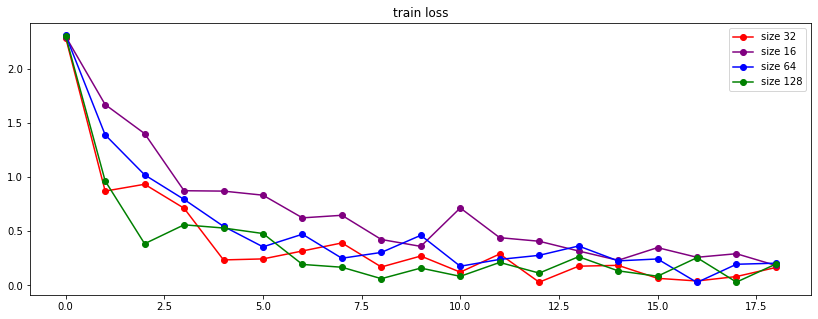

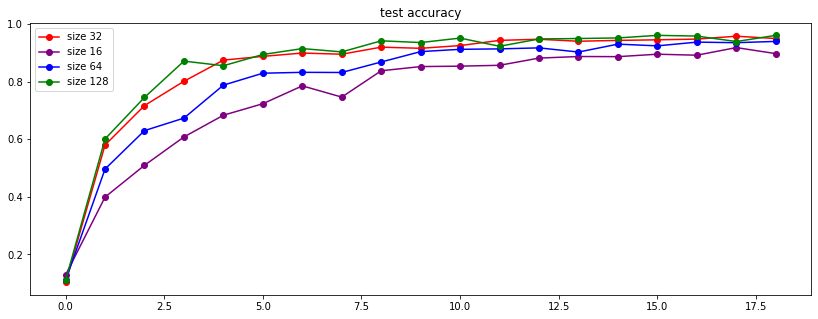

In [47]:
fig = plt.figure(figsize = (14,5))
plt.plot(Rloss[0], label = 'size 32',color = "red", marker = "o")
plt.plot(Rloss[1], label = 'size 16',color = "purple", marker = "o")
plt.plot(Rloss[2], label = 'size 64',color = "blue", marker = "o")
plt.plot(Rloss[3], label = 'size 128',color = "green", marker = "o")
plt.title("train loss")
plt.legend()

fig = plt.figure(figsize = (14,5))
plt.plot(Racc[0], label = 'size 32',color = "red", marker = "o")
plt.plot(Racc[1], label = 'size 16',color = "purple", marker = "o")
plt.plot(Racc[2], label = 'size 64',color = "blue", marker = "o")
plt.plot(Racc[3], label = 'size 128',color = "green", marker = "o")
plt.title("test accuracy")
plt.legend()

In [48]:
opacc = []
oploss = []
opacc.append([])
oploss.append([])
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.RMSprop(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            oploss[0].append(loss.data)
            opacc[0].append(accuracy)
            

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3109 | test accuracy: 0.10
Epoch:  0 | train loss: 1.5358 | test accuracy: 0.41
Epoch:  0 | train loss: 1.2040 | test accuracy: 0.57
Epoch:  0 | train loss: 0.6510 | test accuracy: 0.72
Epoch:  0 | train loss: 0.6583 | test accuracy: 0.69
Epoch:  0 | train loss: 0.3993 | test accuracy: 0.80
Epoch:  0 | train loss: 0.3687 | test accuracy: 0.86
Epoch:  0 | train loss: 0.5178 | test accuracy: 0.88
Epoch:  0 | train loss: 0.4188 | test accuracy: 0.91
Epoch:  0 | train loss: 0.1258 | test accuracy: 0.92
Epoch:  0 | train loss: 0.3936 | test accuracy: 0.92
Epoch:  0 | train loss: 0.2012 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2819 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2442 | test accuracy: 0.94
Epoch:  0 | train loss: 0.4938 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2081 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0867 | test accurac

In [49]:

opacc.append([])
oploss.append([])
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adadelta(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            oploss[1].append(loss.data)
            opacc[1].append(accuracy)
            

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.2932 | test accuracy: 0.09
Epoch:  0 | train loss: 2.2894 | test accuracy: 0.09
Epoch:  0 | train loss: 2.3108 | test accuracy: 0.09
Epoch:  0 | train loss: 2.3151 | test accuracy: 0.10
Epoch:  0 | train loss: 2.3055 | test accuracy: 0.10
Epoch:  0 | train loss: 2.3048 | test accuracy: 0.11
Epoch:  0 | train loss: 2.3105 | test accuracy: 0.12
Epoch:  0 | train loss: 2.3186 | test accuracy: 0.12
Epoch:  0 | train loss: 2.3103 | test accuracy: 0.13
Epoch:  0 | train loss: 2.2971 | test accuracy: 0.11
Epoch:  0 | train loss: 2.3062 | test accuracy: 0.11
Epoch:  0 | train loss: 2.3158 | test accuracy: 0.12
Epoch:  0 | train loss: 2.2971 | test accuracy: 0.12
Epoch:  0 | train loss: 2.2880 | test accuracy: 0.12
Epoch:  0 | train loss: 2.3098 | test accuracy: 0.12
Epoch:  0 | train loss: 2.3018 | test accuracy: 0.12
Epoch:  0 | train loss: 2.3012 | test accurac

In [50]:
opacc.append([])
oploss.append([])
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adagrad(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            oploss[2].append(loss.data)
            opacc[2].append(accuracy)
            

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.2861 | test accuracy: 0.11
Epoch:  0 | train loss: 1.3636 | test accuracy: 0.56
Epoch:  0 | train loss: 0.9223 | test accuracy: 0.64
Epoch:  0 | train loss: 0.7707 | test accuracy: 0.70
Epoch:  0 | train loss: 0.8785 | test accuracy: 0.77
Epoch:  0 | train loss: 0.5878 | test accuracy: 0.79
Epoch:  0 | train loss: 0.5265 | test accuracy: 0.81
Epoch:  0 | train loss: 0.4365 | test accuracy: 0.82
Epoch:  0 | train loss: 0.4808 | test accuracy: 0.85
Epoch:  0 | train loss: 0.3527 | test accuracy: 0.85
Epoch:  0 | train loss: 0.4670 | test accuracy: 0.85
Epoch:  0 | train loss: 0.3725 | test accuracy: 0.85
Epoch:  0 | train loss: 0.2980 | test accuracy: 0.87
Epoch:  0 | train loss: 0.5299 | test accuracy: 0.88
Epoch:  0 | train loss: 0.2820 | test accuracy: 0.88
Epoch:  0 | train loss: 0.3759 | test accuracy: 0.88
Epoch:  0 | train loss: 0.2864 | test accurac

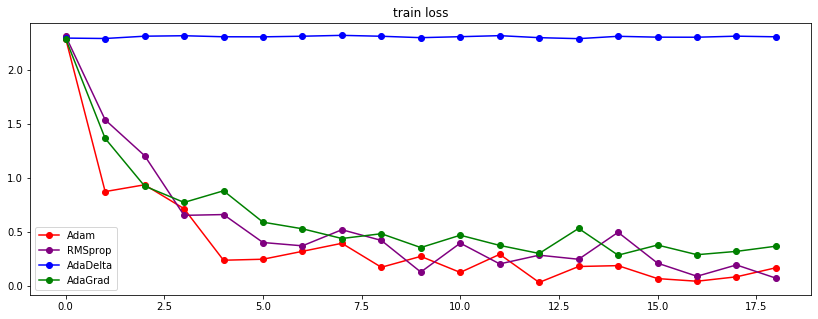

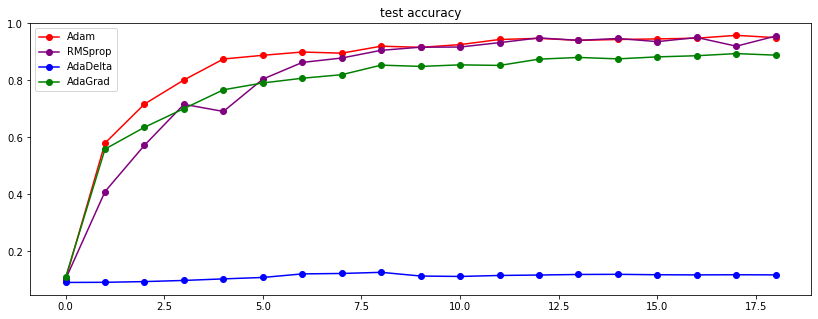

In [51]:
fig = plt.figure(figsize = (14,5))
plt.plot(Rloss[0], label = 'Adam',color = "red", marker = "o")
plt.plot(oploss[0], label = 'RMSprop',color = "purple", marker = "o")
plt.plot(oploss[1], label = 'AdaDelta',color = "blue", marker = "o")
plt.plot(oploss[2], label = 'AdaGrad',color = "green", marker = "o")
plt.title("train loss")
plt.legend()

fig = plt.figure(figsize = (14,5))
plt.plot(Racc[0], label = 'Adam',color = "red", marker = "o")
plt.plot(opacc[0], label = 'RMSprop',color = "purple", marker = "o")
plt.plot(opacc[1], label = 'AdaDelta',color = "blue", marker = "o")
plt.plot(opacc[2], label = 'AdaGrad',color = "green", marker = "o")
plt.title("test accuracy")
plt.legend()

In [52]:
Gacc = []
Gloss = []
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.GRU(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            Gloss.append(loss.data)
            Gacc.append(accuracy)

RNN(
  (rnn): GRU(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3140 | test accuracy: 0.10
Epoch:  0 | train loss: 1.0259 | test accuracy: 0.63
Epoch:  0 | train loss: 0.6576 | test accuracy: 0.79
Epoch:  0 | train loss: 0.2288 | test accuracy: 0.87
Epoch:  0 | train loss: 0.3440 | test accuracy: 0.89
Epoch:  0 | train loss: 0.4115 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2927 | test accuracy: 0.92
Epoch:  0 | train loss: 0.2680 | test accuracy: 0.91
Epoch:  0 | train loss: 0.0977 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1061 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2526 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1663 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2390 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0548 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1328 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0712 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2668 | test accuracy

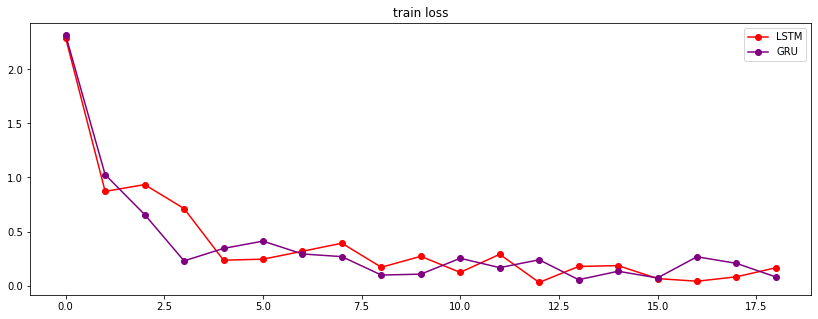

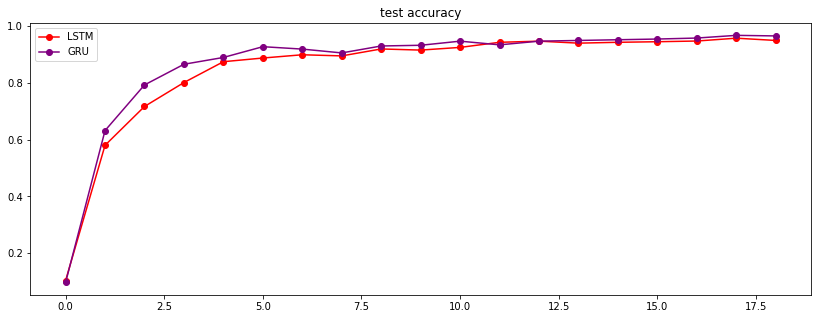

In [53]:
fig = plt.figure(figsize = (14,5))
plt.plot(Rloss[0], label = 'LSTM',color = "red", marker = "o")
plt.plot(Gloss, label = 'GRU',color = "purple", marker = "o")

plt.title("train loss")
plt.legend()

fig = plt.figure(figsize = (14,5))
plt.plot(Racc[0], label = 'LSTM',color = "red", marker = "o")
plt.plot(Gacc, label = 'GRU',color = "purple", marker = "o")

plt.title("test accuracy")
plt.legend()

In [54]:
bacc = []
bloss = []
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=True)

# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
test_x = Variable(test_data.test_data, volatile=True).type(torch.FloatTensor)[:2000]/255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy().squeeze()[:2000]    # covert to numpy array

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            bloss.append(loss.data)
            bacc.append(accuracy)


C:\Users\janek\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3202 | test accuracy: 0.09
Epoch:  0 | train loss: 1.3409 | test accuracy: 0.48
Epoch:  0 | train loss: 0.9594 | test accuracy: 0.56
Epoch:  0 | train loss: 0.6648 | test accuracy: 0.67
Epoch:  0 | train loss: 0.8005 | test accuracy: 0.73
Epoch:  0 | train loss: 0.4948 | test accuracy: 0.79
Epoch:  0 | train loss: 0.5110 | test accuracy: 0.82
Epoch:  0 | train loss: 0.5253 | test accuracy: 0.86
Epoch:  0 | train loss: 0.4935 | test accuracy: 0.84
Epoch:  0 | train loss: 0.3357 | test accuracy: 0.87
Epoch:  0 | train loss: 0.2594 | test accuracy: 0.89
Epoch:  0 | train loss: 0.1662 | test accuracy: 0.91
Epoch:  0 | train loss: 0.2509 | test accuracy: 0.91
Epoch:  0 | train loss: 0.2712 | test accuracy: 0.88
Epoch:  0 | train loss: 0.1609 | test accuracy: 0.92
Epoch:  0 | train loss: 0.5389 | test accuracy: 0.90
Epoch:  0 | train loss: 0.3889 | test accurac

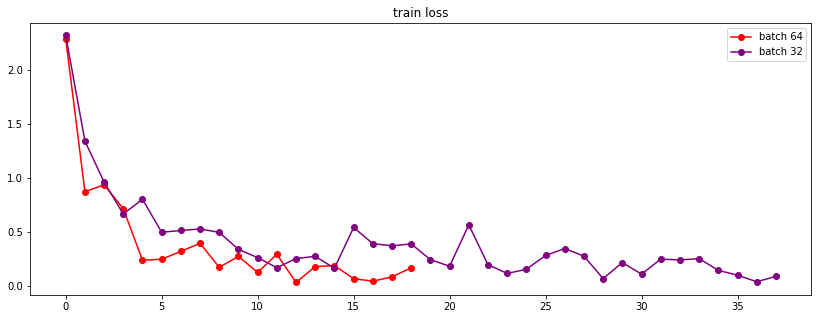

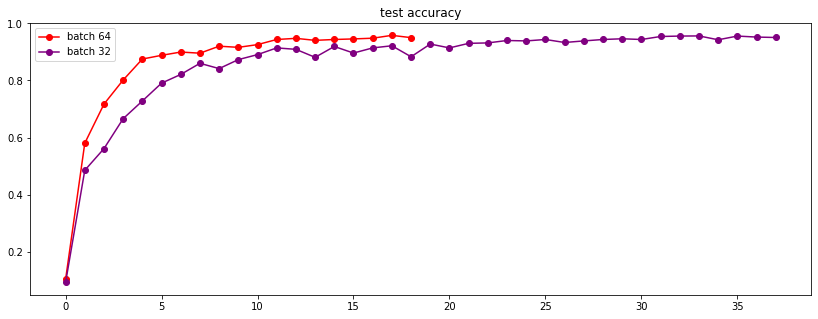

In [55]:
fig = plt.figure(figsize = (14,5))
plt.plot(Rloss[0], label = 'batch 64',color = "red", marker = "o")
plt.plot(bloss, label = 'batch 32',color = "purple", marker = "o")

plt.title("train loss")
plt.legend()

fig = plt.figure(figsize = (14,5))
plt.plot(Racc[0], label = 'batch 64',color = "red", marker = "o")
plt.plot(bacc, label = 'batch 32',color = "purple", marker = "o")

plt.title("test accuracy")
plt.legend()

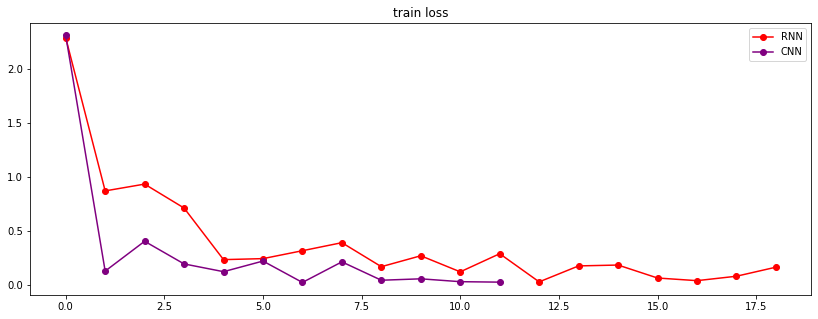

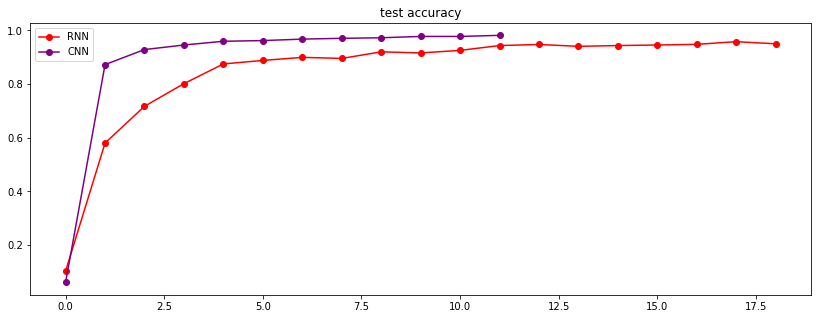

In [56]:
fig = plt.figure(figsize = (14,5))
plt.plot(Rloss[0], label = 'RNN',color = "red", marker = "o")
plt.plot(loss5, label = 'CNN',color = "purple", marker = "o")

plt.title("train loss")
plt.legend()

fig = plt.figure(figsize = (14,5))
plt.plot(Racc[0], label = 'RNN',color = "red", marker = "o")
plt.plot(acc5, label = 'CNN',color = "purple", marker = "o")

plt.title("test accuracy")
plt.legend()

In [57]:
reRacc = []
reRloss = []
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR, weight_decay = 1e-5)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            reRloss.append(loss.data)
            reRacc.append(accuracy)
            

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3310 | test accuracy: 0.11
Epoch:  0 | train loss: 1.3829 | test accuracy: 0.57
Epoch:  0 | train loss: 0.7107 | test accuracy: 0.68
Epoch:  0 | train loss: 0.4635 | test accuracy: 0.74
Epoch:  0 | train loss: 0.5335 | test accuracy: 0.79
Epoch:  0 | train loss: 0.2818 | test accuracy: 0.84
Epoch:  0 | train loss: 0.4233 | test accuracy: 0.83
Epoch:  0 | train loss: 0.6561 | test accuracy: 0.80
Epoch:  0 | train loss: 0.7141 | test accuracy: 0.80
Epoch:  0 | train loss: 0.2386 | test accuracy: 0.86
Epoch:  0 | train loss: 0.5042 | test accuracy: 0.91
Epoch:  0 | train loss: 0.1292 | test accuracy: 0.92
Epoch:  0 | train loss: 0.3419 | test accuracy: 0.92
Epoch:  0 | train loss: 0.1137 | test accuracy: 0.92
Epoch:  0 | train loss: 0.3696 | test accuracy: 0.92
Epoch:  0 | train loss: 0.3007 | test accuracy: 0.92
Epoch:  0 | train loss: 0.3927 | test accurac

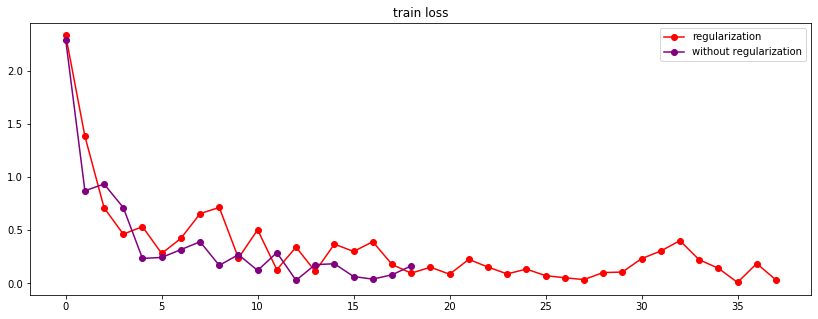

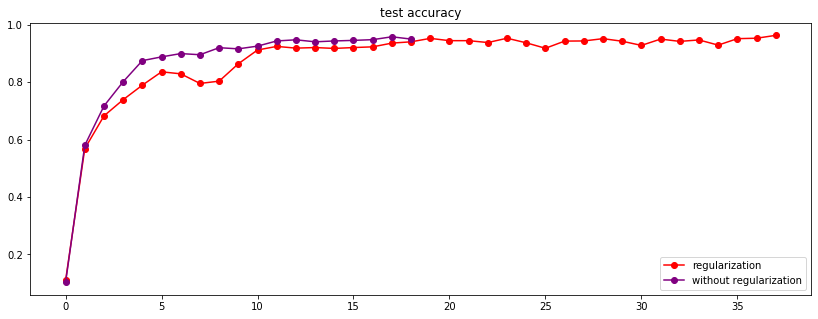

In [58]:
fig = plt.figure(figsize = (14,5))
plt.plot(reRloss, label = 'regularization',color = "red", marker = "o")
plt.plot(Rloss[0], label = 'without regularization',color = "purple", marker = "o")

plt.title("train loss")
plt.legend()

fig = plt.figure(figsize = (14,5))
plt.plot(reRacc, label = 'regularization',color = "red", marker = "o")
plt.plot(Racc[0], label = 'without regularization',color = "purple", marker = "o")

plt.title("test accuracy")
plt.legend()

In [59]:
dropRacc = []
dropRloss = []
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
            dropout = 0.2,
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN()
print(rnn)

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        b_x = Variable(x.view(-1, 28, 28))              # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)                               # batch y

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
            dropRloss.append(loss.data)
            dropRacc.append(accuracy)
            

C:\Users\janek\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


RNN(
  (rnn): LSTM(28, 64, batch_first=True, dropout=0.2)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3101 | test accuracy: 0.10
Epoch:  0 | train loss: 1.3769 | test accuracy: 0.52
Epoch:  0 | train loss: 0.9156 | test accuracy: 0.63
Epoch:  0 | train loss: 0.7152 | test accuracy: 0.67
Epoch:  0 | train loss: 0.5651 | test accuracy: 0.71
Epoch:  0 | train loss: 0.3761 | test accuracy: 0.77
Epoch:  0 | train loss: 0.8461 | test accuracy: 0.79
Epoch:  0 | train loss: 0.7034 | test accuracy: 0.81
Epoch:  0 | train loss: 0.2354 | test accuracy: 0.88
Epoch:  0 | train loss: 0.2869 | test accuracy: 0.90
Epoch:  0 | train loss: 0.2665 | test accuracy: 0.89
Epoch:  0 | train loss: 0.3332 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2870 | test accuracy: 0.92
Epoch:  0 | train loss: 0.1327 | test accuracy: 0.89
Epoch:  0 | train loss: 0.2723 | test accuracy: 0.90
Epoch:  0 | train loss: 0.1157 | test accuracy: 0.91
Epoch:  0 | train loss: 0.0899 |

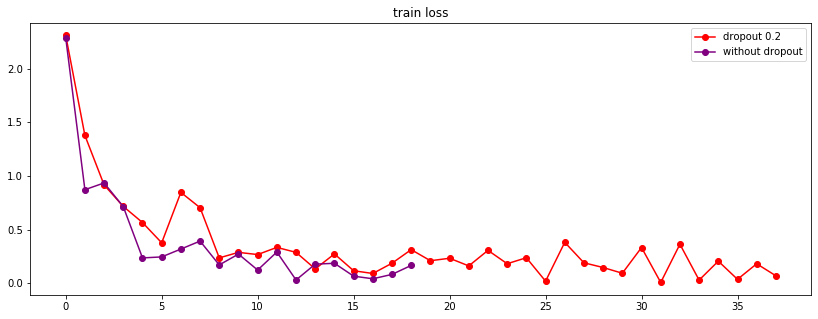

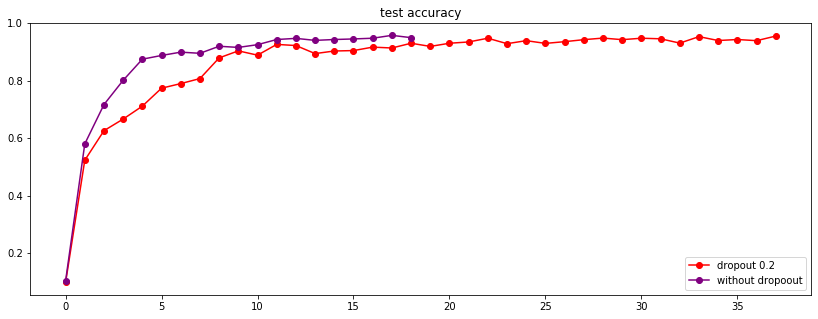

In [60]:
fig = plt.figure(figsize = (14,5))
plt.plot(dropRloss, label = 'dropout 0.2',color = "red", marker = "o")
plt.plot(Rloss[0], label = 'without dropout',color = "purple", marker = "o")

plt.title("train loss")
plt.legend()

fig = plt.figure(figsize = (14,5))
plt.plot(dropRacc, label = 'dropout 0.2',color = "red", marker = "o")
plt.plot(Racc[0], label = 'without dropoout',color = "purple", marker = "o")

plt.title("test accuracy")
plt.legend()